### Process Data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import palettable
from file_processor import FileProcessor
import word2vec
import som
from mlp import MLP

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

In [2]:
folder_path = "data/enron"
class_names = os.listdir(folder_path)
print(class_names)

['ham', 'spam']


In [3]:
num_classes = len(class_names)
print(num_classes)

2


### Split file into paragraphs

In [4]:
fp1 = FileProcessor()

In [5]:
data, classes = fp1.read_files(folder_path)

In [6]:
print(len(data), len(classes))

11408 11408


In [7]:
corpus, classes = fp1.make_corpus(data, classes, min_sent_size=1)

In [8]:
print(len(corpus), len(classes))

14505 14505


### Use Skip-gram to create word embeddings for the email dataset

In [9]:
targets_int, contexts_int, unique_words, classes, word2ind, ind2word = fp1.prepare("data/enron")

In [10]:
print(len(targets_int), len(contexts_int), len(unique_words), len(classes), len(word2ind), len(ind2word))

81620 81620 10045 10045 10045 10045


In [11]:
vocab_sz = len(unique_words)
print(vocab_sz)
M = vocab_sz
H = 20
C = vocab_sz
batch_sz = 11

net = word2vec.Skipgram(M, H, C, wt_stdev=0.1)

dev_targets_int = targets_int[0:10]
dev_contexts_int = contexts_int[0:10]
hist_1 = net.fit(dev_targets_int, dev_contexts_int, mini_batch_sz=batch_sz, lr=1e-2, n_epochs=400, print_every=50, verbose=True)

10045
Starting to train network ....
Epoch 0/400, Training Loss: 28.45%.
Epoch 50/400, Training Loss: 6.31%.
Epoch 100/400, Training Loss: 4.20%.
Epoch 150/400, Training Loss: 3.78%.
Epoch 200/400, Training Loss: 3.69%.
Epoch 250/400, Training Loss: 3.66%.
Epoch 300/400, Training Loss: 3.65%.
Epoch 350/400, Training Loss: 3.64%.


C:\Users\wenmu\OneDrive\Documents\Spring 2023\CS 443\CS443_Projects\p4_version2\word2vec.py:360: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation=0)


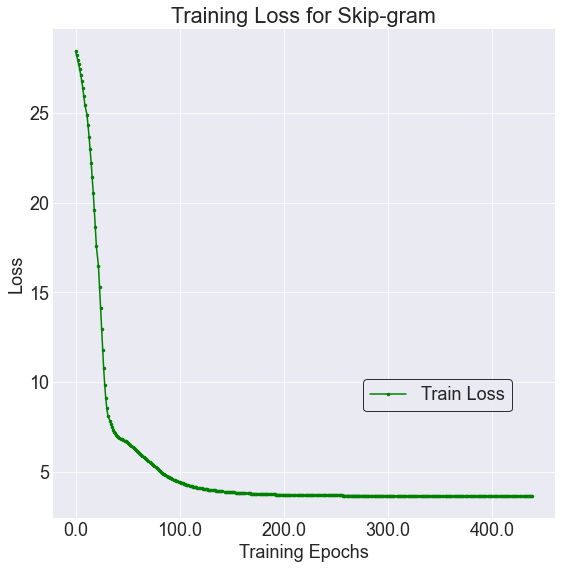

In [12]:
net.plot_train_loss(hist_1, n_samps=dev_targets_int.shape[0], batch_sz=batch_sz)

### 2. Start to train on a large number of dataset

In [15]:
vocab_sz = len(unique_words)
M = vocab_sz
H = 50
C = vocab_sz
batch_sz = 2000

skipgram = word2vec.Skipgram(M, H, C, wt_stdev=0.1)

print(len(targets_int), len(contexts_int))

hist_1 = skipgram.fit(targets_int, contexts_int, mini_batch_sz=batch_sz, lr=1e-2, n_epochs=200, print_every=10, verbose=True)

81620 81620
Starting to train network ....



KeyboardInterrupt



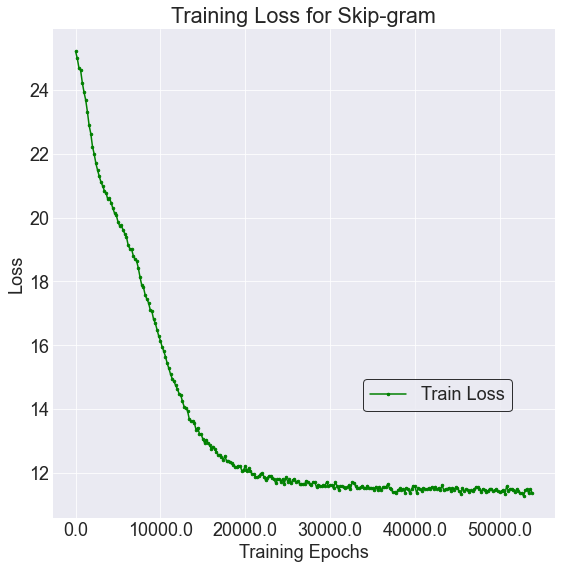

In [40]:
skipgram.plot_train_loss(hist_1, n_samps=dev_targets_int.shape[0], batch_sz=batch_sz)

### b. build training dataset for MLP network

In [41]:
def create_splits(data, y, n_train_samps=3500, n_test_samps=500, n_valid_samps=500, n_dev_samps=500):
    '''Divides the dataset up into train/test/validation/development "splits" (disjoint partitions)

    Parameters:
    ----------
    data: float64 ndarray. Image data. shape=(Num imgs, height*width*chans)
    y: ndarray. int-coded labels.

    Returns:
    ----------
    None if error
    x_train (training samples),
    y_train (training labels),
    x_test (test samples),
    y_test (test labels),
    x_val (validation samples),
    y_val (validation labels),
    x_dev (development samples),
    y_dev (development labels)

    TODO:
    1) Divvy up the images into train/test/validation/development non-overlapping subsets (see return vars)

    NOTE: Resist the urge to shuffle the data here! It is best to re-shuffle the data after
    each epoch of training so hold off on shuffling until you train your neural network.
    '''

    if n_train_samps + n_test_samps + n_valid_samps + n_dev_samps != len(data):
        samps = n_train_samps + n_test_samps + n_valid_samps + n_dev_samps
        print(f'Error! Num samples {samps} does not equal num images {len(data)}!')
        return

    i = n_train_samps
    x_train = data[:i,:]
    y_train = y[:i]


    x_test = data[i:i+n_test_samps,:]
    y_test = y[i:i+n_test_samps]

    i+= n_test_samps

    x_val = data[i:i+n_valid_samps,:]
    y_val = y[i:i+n_valid_samps]

    i+= n_valid_samps

    x_dev = data[i:i+n_dev_samps,:]
    y_dev = y[i:i+n_dev_samps]

    return(x_train,y_train,x_test,y_test,x_val,y_val,x_dev,y_dev)

In [42]:
x = skipgram.get_all_word_vectors(word2ind, unique_words)
y = classes

print(x.shape, y.shape)

(878, 50) (878,)


In [43]:
x_train,y_train,x_test,y_test,x_val,y_val,x_dev,y_dev = create_splits(x, y, n_train_samps=400, n_test_samps=40, n_valid_samps=400, n_dev_samps=38)

In [44]:
mlp_net = MLP(num_input_units=50, num_hidden_units=300, num_output_units=13)
loss_hist, acc_train, acc_valid = mlp_net.fit(x_train, y_train, x_val, y_val,
            resume_training=False, n_epochs=100, lr=0.1, mini_batch_sz=50, reg=0.001, verbose=2,
            print_every=100)

Starting to train network...There will be 100 epochs and 800 iterations total, 8 iter/epoch.
 Completed Epoch 0/100. Training loss: 3.07. Validation Accuracy: 13.00%.
Finished training!


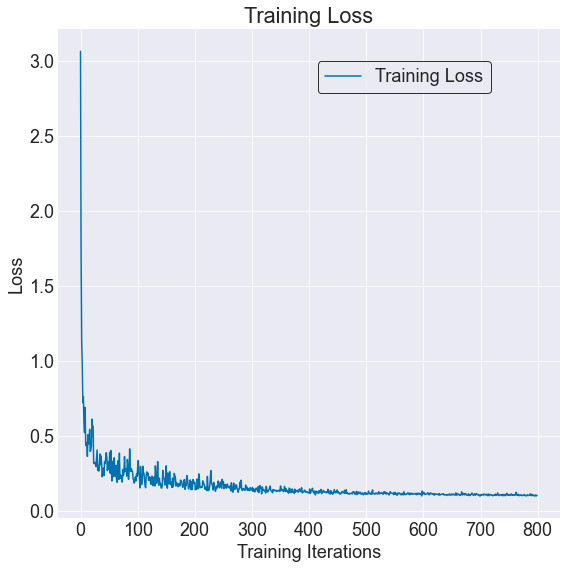

In [47]:
def plot_loss(loss_history):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
    axes.plot(loss_history, label='Training Loss')
    
    # Axes.set_xlabel(xlabel)
    axes.set_xlabel("Training Iterations")
    axes.set_ylabel("Loss")
    
    axes.legend(loc="lower left", bbox_to_anchor=(0.5, 0.85), frameon=True, edgecolor="black")

    axes.set_title('Training Loss')
    plt.savefig("img/mlp_training_loss.svg")
    plt.show()
    
plot_loss(loss_hist)

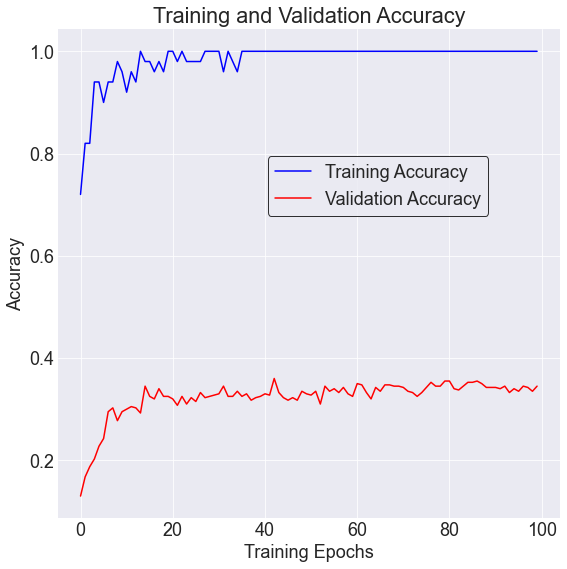

In [50]:
def plot_accuracy(train_acc, val_acc):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
    axes.plot(train_acc, 'b-', markersize=10, label='Training Accuracy')
    axes.plot(val_acc, 'r-', markersize=10, label='Validation Accuracy')

    # Axes.set_xlabel(xlabel)
    axes.set_xlabel("Training Epochs")
    axes.set_ylabel("Accuracy")

    # frameon: Whether the legend should be drawn on a patch (frame).
    axes.legend(loc="lower left", bbox_to_anchor=(0.4, 0.6), frameon=True, edgecolor="black")

    axes.set_title('Training and Validation Accuracy')
    plt.savefig("img/mlp_train_valid_acc.svg")
    plt.show()
    
plot_accuracy(acc_train, acc_valid)

In [51]:
a = np.array([[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0]])
print(a.argmax(axis=1))

[1 0 2]


In [52]:
print(len(unique_words))

878


In [54]:
num_words_to_visualize = 878
word_inds = np.random.choice(len(unique_words), size=num_words_to_visualize, replace=False)
print(x.shape)
word_vecs = x[word_inds,:]
word_strings = np.array(unique_words)[word_inds]


print(word_vecs.shape, word_strings.shape)

(878, 50)
(878, 50) (878,)


In [55]:
c = classes[word_inds]
print(len(c))

878


In [56]:
data = word_vecs / np.sqrt(np.sum(word_vecs**2, axis=1, keepdims=True))

In [37]:
# Your code here

n_epochs = 50
lr = 3
som_sz = (100, 100)
sigma = 100
n_features = data.shape[1]

imdb_som_2 = som.SOM(map_sz=som_sz, num_feats=n_features)
print(imdb_som_2.get_wts()[0, 0, :5])

[-0.2097322  0.0430029  0.1575897 -0.366937   0.1088285]


In [38]:
imdb_som_2.initialize_wts_with_pc(data)

test


In [39]:
imdb_som_2.fit(x = data, n_epochs=n_epochs, lr=lr, lr_decay=0.9999, sigma=sigma, sigma_decay=0.9999, print_every=1, verbose=True)

Starting to train network ....
Epoch 0/50, Learning rate: 2.7470, Sigma: 91.5665, Error: 1.3803.
Epoch 1/50, Learning rate: 2.5153, Sigma: 83.8443, Error: 1.2906.
Epoch 2/50, Learning rate: 2.3032, Sigma: 76.7733, Error: 1.3001.
Epoch 3/50, Learning rate: 2.1090, Sigma: 70.2986, Error: 1.2408.
Epoch 4/50, Learning rate: 1.9311, Sigma: 64.3700, Error: 1.1952.
Epoch 5/50, Learning rate: 1.7682, Sigma: 58.9414, Error: 1.1509.
Epoch 6/50, Learning rate: 1.6191, Sigma: 53.9706, Error: 1.0892.
Epoch 7/50, Learning rate: 1.4826, Sigma: 49.4190, Error: 1.0605.
Epoch 8/50, Learning rate: 1.3575, Sigma: 45.2513, Error: 1.1160.
Epoch 9/50, Learning rate: 1.2431, Sigma: 41.4350, Error: 1.0924.
Epoch 10/50, Learning rate: 1.1382, Sigma: 37.9406, Error: 1.0663.
Epoch 11/50, Learning rate: 1.0422, Sigma: 34.7409, Error: 1.0160.
Epoch 12/50, Learning rate: 0.9543, Sigma: 31.8110, Error: 1.0342.
Epoch 13/50, Learning rate: 0.8738, Sigma: 29.1283, Error: 1.0019.
Epoch 14/50, Learning rate: 0.8002, Sigma

In [40]:
cmap = plt.cm.get_cmap("tab20")
print(cmap(0.1))
colors=[]
for i in range(20):
    c1 = matplotlib.colors.to_hex(cmap(i*0.05))
    colors.append(c1)
print(colors)

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


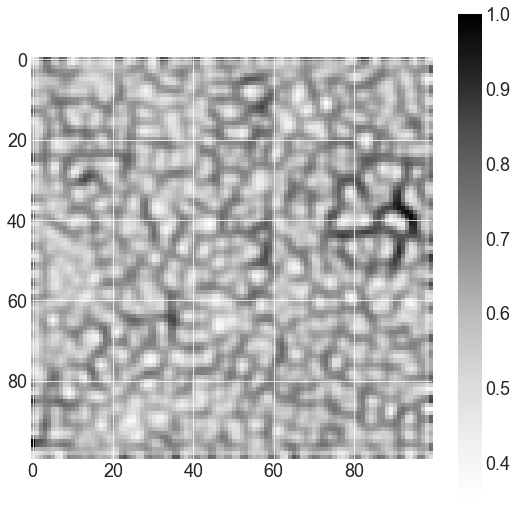

In [41]:
u_matrix_3, dict_neigh = imdb_som_2.u_matrix()

def plot_umatrix(u_matrix, x=None, y=None, iris_y=None, markers=None, colors=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
    cb = axes.imshow(u_matrix, cmap=palettable.colorbrewer.sequential.Greys_9.mpl_colormap)
    # axes.scatter(x=x, y=y, c=iris_y)
    if iris_y is not None:
        for i in range(len(iris_y)):
            c = iris_y[i]
            axes.scatter(x=x[i], y=y[i], c=colors[c], marker=markers[c])
    
    plt.savefig("img/u_matrix.svg")
    plt.colorbar(cb)
    
plot_umatrix(u_matrix_3)

In [50]:
num_words_to_visualize = 100

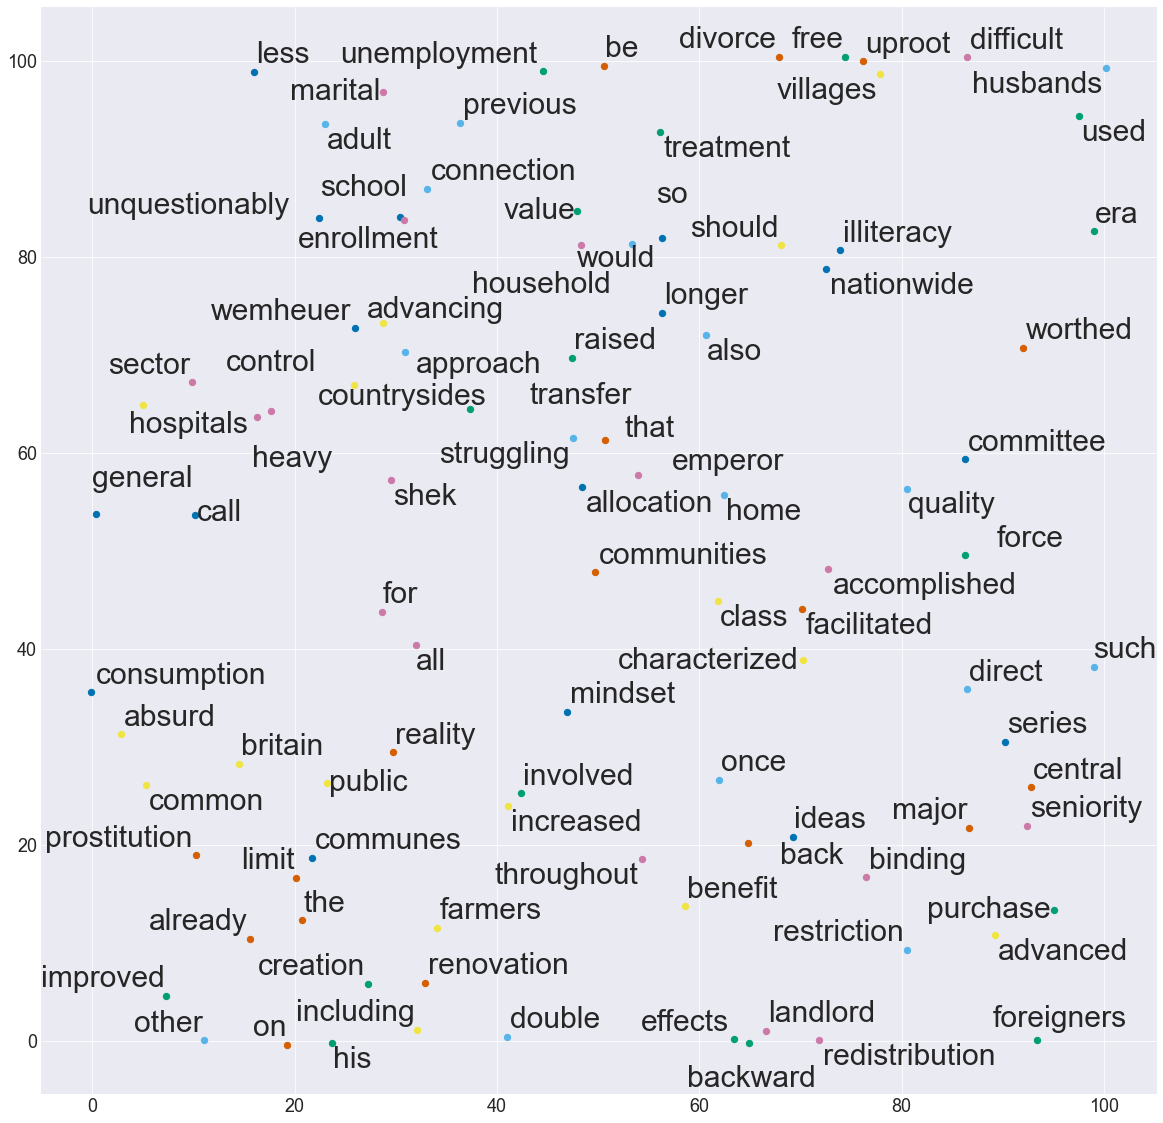

In [51]:
from adjustText import adjust_text

np.random.seed(0)

word_inds = np.random.choice(len(word_vecs), size=num_words_to_visualize, replace=False)

jitter = 1
jitter_xy = np.random.uniform(low=-jitter, high=jitter, size=(num_words_to_visualize, 2))

fig, ax = plt.subplots(figsize=(20, 20))
# cb = ax.imshow(u_matrix_3, cmap=palettable.colorbrewer.sequential.Greys_9.mpl_colormap)
texts = []
for i, ind in enumerate(word_inds):
    bmu_pos = imdb_som_2.get_bmu(word_vecs[ind])
    # jitter the placement of words so that they are less likely to plot ontop of each other
    x = bmu_pos[0] + 0.5 + jitter_xy[i, 0]
    y = bmu_pos[1] + 0.5 + jitter_xy[i, 1]
    ax.scatter(x, y, s=40)
    texts.append(ax.annotate(str(word_strings[ind]), xy=(x, y), fontsize=30))
adjust_text(texts)
plt.savefig("img/word_cloud.svg")
plt.show()

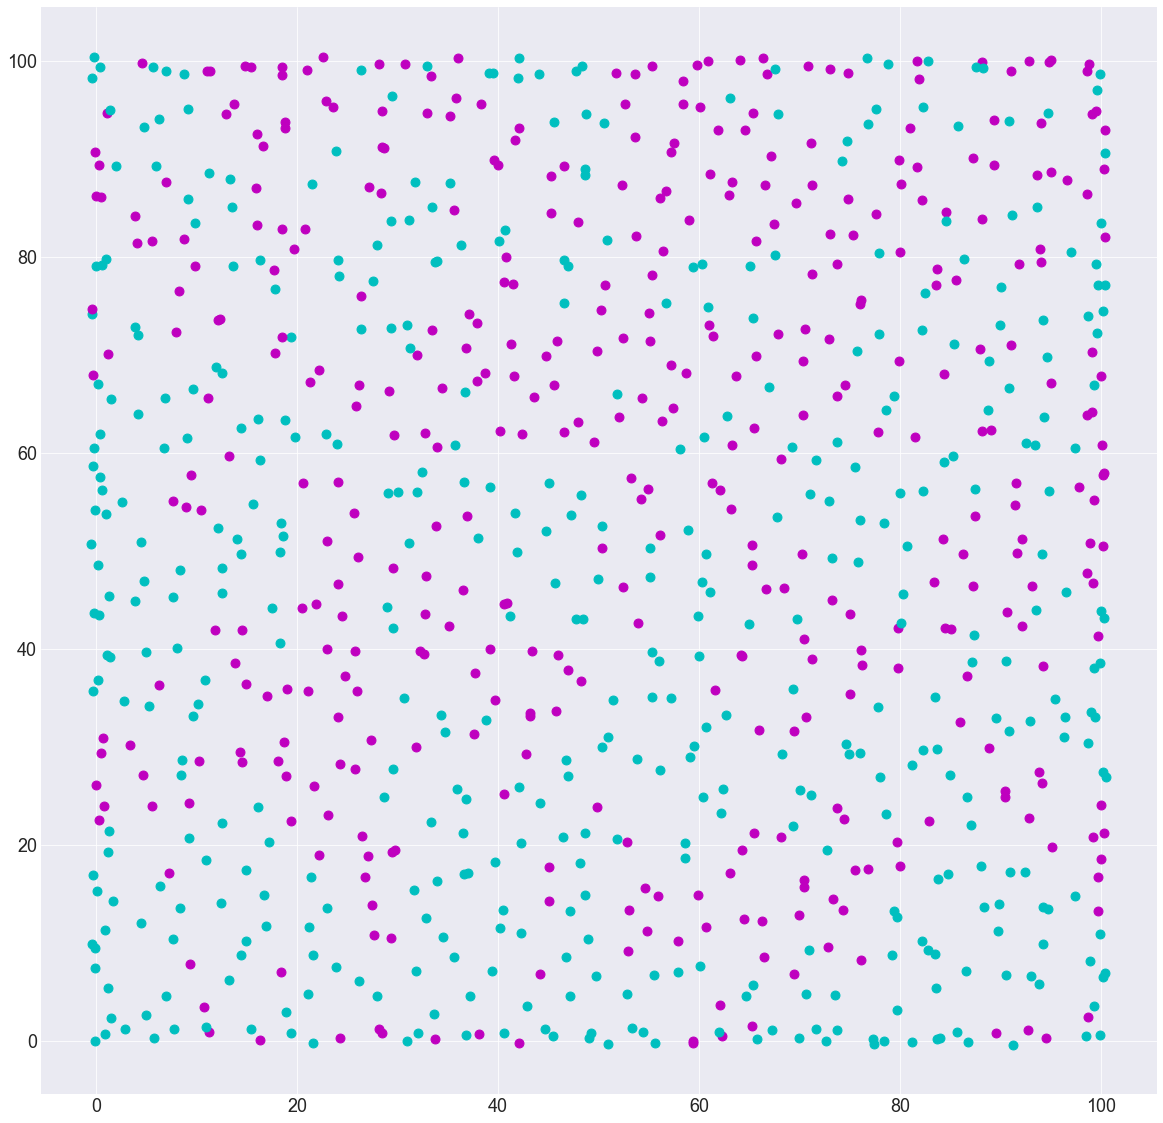

In [64]:
num_words_to_visualize = 881
colors = ["c", "m"]

jitter = 1
jitter_xy = np.random.uniform(low=-jitter, high=jitter, size=(num_words_to_visualize, 2))

fig, ax = plt.subplots(figsize=(20, 20))

texts = []
for i in range(num_words_to_visualize):
    bmu_pos = imdb_som_2.get_bmu(word_vecs[i])
    # jitter the placement of words so that they are less likely to plot ontop of each other
    x_pos = bmu_pos[0] + 0.5 + jitter_xy[i, 0]
    y_pos = bmu_pos[1] + 0.5 + jitter_xy[i, 1]
    ax.scatter(x_pos, y_pos, s=80, c=colors[c[i]])
    # texts.append(ax.annotate(str(word_strings[i]), xy=(x, y), fontsize=30))
# adjust_text(texts)
# cb = ax.imshow(u_matrix_3, cmap=palettable.colorbrewer.sequential.Greys_9.mpl_colormap)
plt.savefig("img/classified_som.svg")
plt.show()